In [1]:
import os
import sys

#sys.path.append('../')

import ot
import torch  # noqa: E402
import pickle  # noqa: E402
import random  # noqa: E402
import numpy as np  # noqa: E402
import seaborn as sns
import pytorch_lightning as pl  # noqa: E402
import matplotlib.pyplot as plt

from Online_GMM import Online_GMM

from pydil.ipms.ot_ipms import (  # noqa: E402
    JointWassersteinDistance
)
from pydil.dadil.labeled_dictionary import LabeledDictionary  # noqa: E402
from pydil.dadil.labeled_dictionary_GMM import LabeledDictionaryGMM
from pydil.ot_utils.barycenters import wasserstein_barycenter  # noqa: E402
from pydil.torch_utils.measures import (  # noqa: E402
    UnsupervisedDatasetMeasure,
    SupervisedDatasetMeasure
)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())
C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = np.load(r'C:\Users\SL276123\Documents\Online DaDiL\CSTR\data\cstr_acfmeandata.npy')

In [3]:
dataset.shape

(2860, 18)

In [4]:
X = dataset[:, :-4]
y = dataset[:, -4]
d = dataset[:, -3]

n_domains = int(np.max(d)) + 1
n_features = X.shape[1]

In [5]:
X.shape, y.shape, d.shape

((2860, 14), (2860,), (2860,))

In [6]:
Xs, ys = [], []
for i in range(n_domains-1):
    Xs.append(torch.from_numpy(X[np.where(d == i)[0]]).float())
    ys.append(torch.from_numpy(y[np.where(d == i)[0]]).float())

In [7]:
Xt = torch.from_numpy(X[np.where(d == n_domains-1)[0]]).float()
yt = torch.from_numpy(y[np.where(d == n_domains-1)[0]]).float()

In [8]:
proj = TSNE(n_components=2).fit_transform(
    torch.cat(Xs + [Xt], dim=0)
)

In [9]:
names = [f'domain {i}' for i in range(7)]

In [10]:
target_name = names[-1]

(0.0, 1.0, 0.0, 1.0)

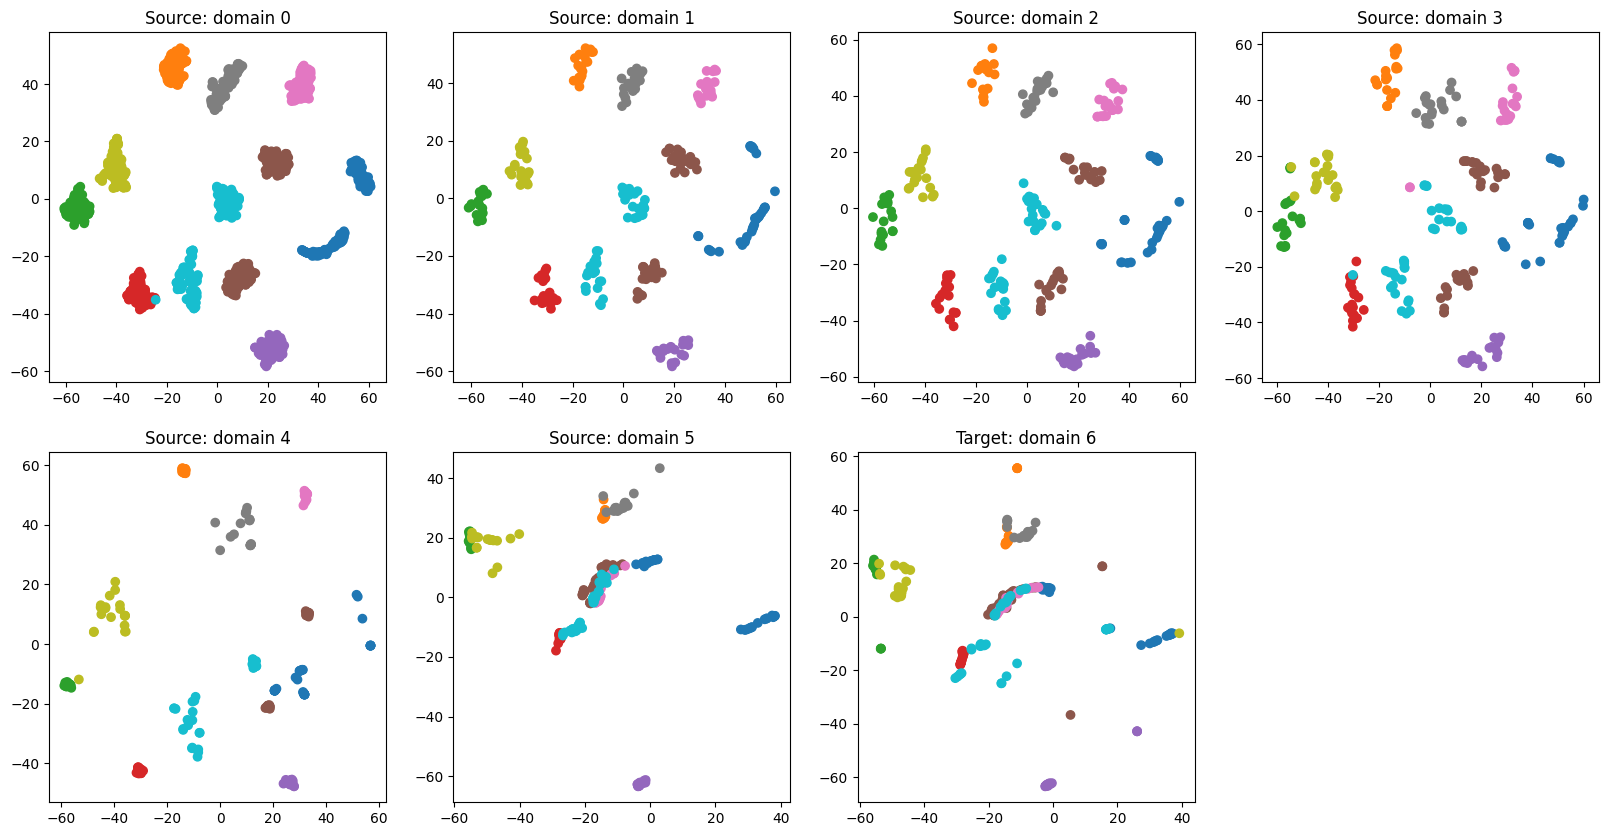

In [11]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-1]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys + [yt], dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
        
axes.flatten()[-1].axis('off')

In [12]:
n_samples = 1300
batch_size = 260
n_components = 3

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_t = torch.from_numpy(X_train)
X_test_t = torch.from_numpy(X_test)
X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[np.where(d==6)[0], :], y[np.where(d==6)[0]], test_size=0.2, random_state=0)
X_train_target_t = torch.from_numpy(X_train_target)
X_test_target_t = torch.from_numpy(X_test_target)

In [70]:
range_data = np.mean(np.max(X[np.where(d!=6)[0], :], axis=0) - np.min(X[np.where(d!=6)[0], :], axis=0))

K_max = 13
OGMM = Online_GMM(
    n_components=K_max, 
    lr=0.1,
    n_features=n_features,
    data_range=range_data
)

for x in X_train_target_t:
    OGMM.fit_sample(x.reshape(-1, n_features))
    
OGMM.generate_list()

[[tensor(0.2722),
  tensor(72.7053),
  tensor([0.0232, 0.0283, 0.0170, 0.0282, 0.0132, 0.1910, 0.0135, 0.1814, 0.0190,
          0.2076, 0.0262, 0.0280, 0.0168, 0.1606], dtype=torch.float64),
  tensor([[ 1.5056e-04, -3.5474e-06,  1.1576e-06, -1.3325e-08, -1.5141e-05,
           -4.5202e-04, -1.9168e-05, -4.2388e-04, -5.3935e-05, -5.6247e-04,
            8.9971e-05, -1.1593e-05, -2.0333e-05, -4.2254e-04],
          [-3.5474e-06,  2.0608e-06,  1.7168e-07, -3.2541e-07,  4.7036e-07,
            3.4200e-05,  8.5627e-07,  3.3050e-05,  3.2978e-06,  3.9525e-05,
           -3.6771e-07,  6.4752e-07, -1.6938e-06,  3.2161e-05],
          [ 1.1576e-06,  1.7168e-07,  2.7791e-05,  4.9499e-08,  8.4718e-07,
            1.1338e-04,  4.2214e-06,  1.0521e-04, -1.0686e-05,  1.6395e-04,
           -4.3917e-06, -4.0931e-07,  1.3127e-05,  9.6109e-05],
          [-1.3325e-08, -3.2541e-07,  4.9499e-08,  1.1152e-06,  5.9023e-08,
           -5.2680e-06,  6.2537e-07, -5.6013e-06, -1.4924e-06, -7.6949e-06,
        

Test to determine the best K_max

In [ ]:
range_data = np.mean(np.max(X[np.where(d!=6)[0], :], axis=0) - np.min(X[np.where(d!=6)[0], :], axis=0))

K_max = np.linspace(13, 63, 11)
ll = []
for kmax in K_max:
    OGMM = Online_GMM(
        n_components=kmax, 
        lr=0.1,
        n_features=n_features,
        data_range=range_data
    )
    for x in X_train_target_t:
        OGMM.fit_sample(x.reshape(-1, n_features))

    print(OGMM.generate_list())
    ll.append(OGMM.log_likelihood(X_test_target_t))

Text(0, 0.5, 'Log likelihood')

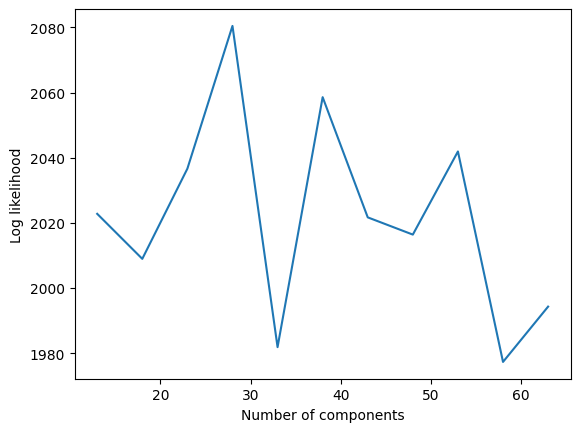

In [69]:
fig, ax = plt.subplots()
ax.plot(K_max, ll)
ax.set_xlabel('Number of components')
ax.set_ylabel('Log likelihood')

In [30]:
ll

[nan,
 2022.801765083162,
 2036.6632238575146,
 1981.8864529478215,
 2021.7148018451246,
 2041.9383045559646]

In [20]:
OGMM.log_likelihood(X_test_target_t)

2022.801765083162

In [18]:
from sklearn.mixture import GaussianMixture
sk_gmm = GaussianMixture(n_components=K_max).fit(X_train_target_t)
np.sum(sk_gmm.score_samples(X_test_target))

-2696.325769872035

In [15]:
Q = []
for Xs_k, ys_k in zip(Xs, ys):
    Q.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q.append(OGMM)

In [16]:
criterion = JointWassersteinDistance()

In [17]:
dictionary = LabeledDictionary(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [18]:
dictionary.fit(Q,
               n_iter_max=60,
               batches_per_it=n_samples // batch_size,
               verbose=True)

100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


It 0/60, Loss: 109.28148345947265


100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


It 1/60, Loss: 47.90048446655273


100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


It 2/60, Loss: 20.35514602661133


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


It 3/60, Loss: 9.439674758911133


100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


It 4/60, Loss: 4.837237787246704


100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


It 5/60, Loss: 2.9617042541503906


100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


It 6/60, Loss: 2.0862736463546754


100%|██████████| 5/5 [00:10<00:00,  2.05s/it]


It 7/60, Loss: 1.6256280422210692


100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


It 8/60, Loss: 1.2795324087142943


100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


It 9/60, Loss: 1.062558400630951


100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


It 10/60, Loss: 0.9301127791404724


100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


It 11/60, Loss: 0.8542154431343079


100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


It 12/60, Loss: 0.7929333925247193


100%|██████████| 5/5 [00:10<00:00,  2.01s/it]


It 13/60, Loss: 0.7687578320503234


100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


It 14/60, Loss: 0.7597110033035279


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


It 15/60, Loss: 0.7244542002677918


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


It 16/60, Loss: 0.7198612689971924


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


It 17/60, Loss: 0.7163828253746033


100%|██████████| 5/5 [00:09<00:00,  1.90s/it]


It 18/60, Loss: 0.7201100587844848


100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


It 19/60, Loss: 0.6811237812042236


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


It 20/60, Loss: 0.6847958445549012


100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


It 21/60, Loss: 0.6756115436553956


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


It 22/60, Loss: 0.6786458849906921


100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


It 23/60, Loss: 0.6471067070960999


100%|██████████| 5/5 [00:09<00:00,  1.96s/it]


It 24/60, Loss: 0.6134775519371033


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


It 25/60, Loss: 0.553696870803833


100%|██████████| 5/5 [00:10<00:00,  2.01s/it]


It 26/60, Loss: 0.49999716877937317


100%|██████████| 5/5 [00:10<00:00,  2.04s/it]


It 27/60, Loss: 0.42547441720962526


100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


It 28/60, Loss: 0.36362754702568056


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


It 29/60, Loss: 0.3242991745471954


100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


It 30/60, Loss: 0.29855992197990416


100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


It 31/60, Loss: 0.287904816865921


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


It 32/60, Loss: 0.2817374110221863


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


It 33/60, Loss: 0.2672745525836944


100%|██████████| 5/5 [00:12<00:00,  2.51s/it]


It 34/60, Loss: 0.26640861630439755


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


It 35/60, Loss: 0.2670387506484985


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


It 36/60, Loss: 0.26838619709014894


100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


It 37/60, Loss: 0.26087514162063596


100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


It 38/60, Loss: 0.26183889210224154


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


It 39/60, Loss: 0.2525955498218536


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


It 40/60, Loss: 0.2588917434215546


100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


It 41/60, Loss: 0.24696531593799592


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


It 42/60, Loss: 0.23530111908912657


100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


It 43/60, Loss: 0.23692345917224886


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


It 44/60, Loss: 0.2518333494663238


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


It 45/60, Loss: 0.24009983539581298


100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


It 46/60, Loss: 0.2507345795631408


100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


It 47/60, Loss: 0.23847149908542634


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


It 48/60, Loss: 0.2489247381687164


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


It 49/60, Loss: 0.23711009919643403


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


It 50/60, Loss: 0.2370339274406433


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


It 51/60, Loss: 0.23072356283664702


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


It 52/60, Loss: 0.24168356359004972


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


It 53/60, Loss: 0.23170414268970488


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


It 54/60, Loss: 0.22363162338733672


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


It 55/60, Loss: 0.23603975772857666


100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


It 56/60, Loss: 0.2228530764579773


100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


It 57/60, Loss: 0.22466800808906556


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


It 58/60, Loss: 0.23130652010440828


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]

It 59/60, Loss: 0.22995685338974


(0.0, 1.0, 0.0, 1.0)

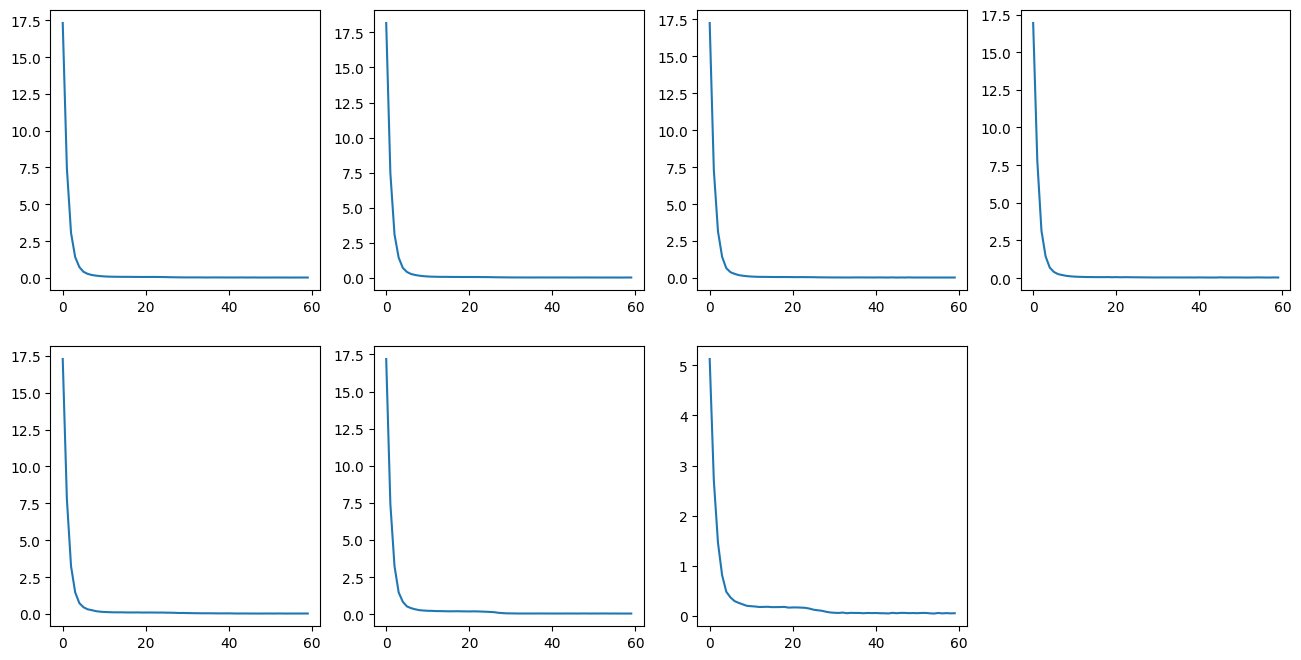

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for k, d in enumerate(dictionary.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary.history['loss_per_dataset'][d])
axes.flatten()[-1].axis('off')

(0.0, 1.0, 0.0673781655728817, 0.7154823370277882)

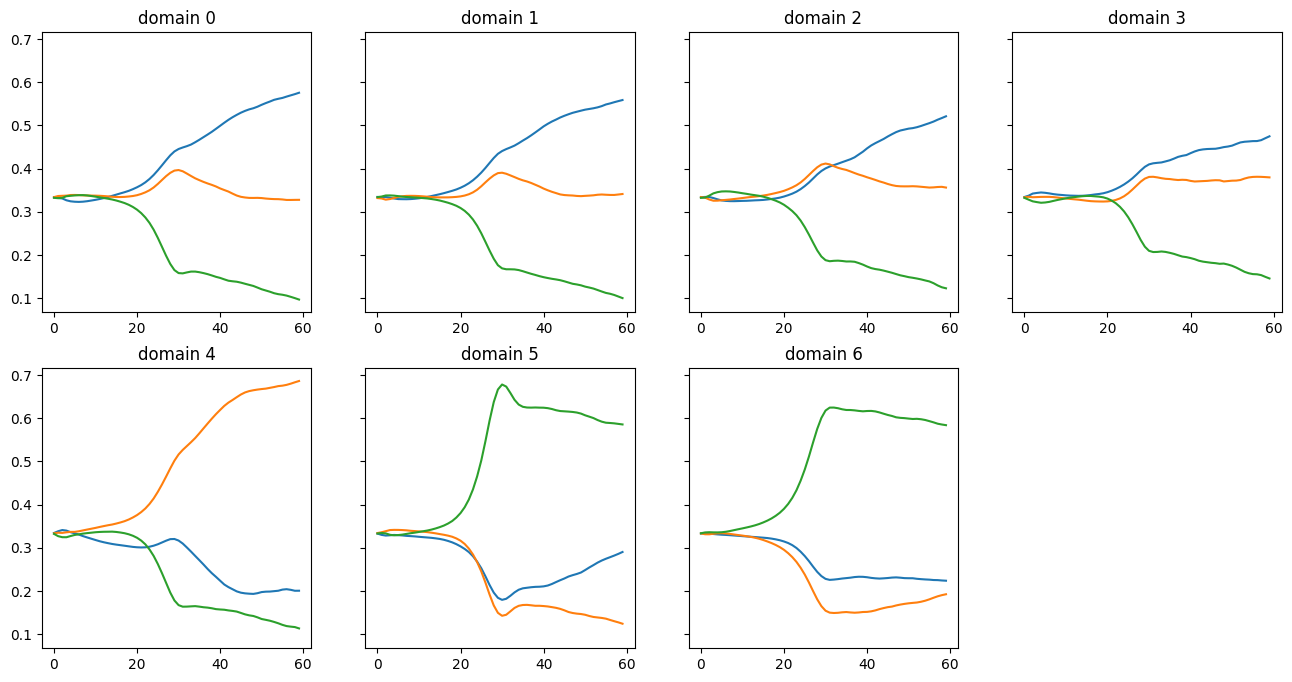

In [20]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names, axes.flatten())):
    ax.plot(torch.stack(dictionary.history['weights'])[:, k, :])
    ax.set_title(name)
axes.flatten()[-1].axis('off')

In [21]:
weights = dictionary.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary.YP]

tensor([0.2238, 0.1924, 0.5838])


In [22]:
Xr, Yr = wasserstein_barycenter(
    XP=XP,
    YP=YP,
    n_samples=n_samples,
    weights=weights,
    tol=1e-9,
    n_iter_max=10,
    propagate_labels=True,
    penalize_labels=True
)

Classification without DA

In [23]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'log_loss')
clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.6038461538461538


DaDiL-E

In [24]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier(criterion = 'log_loss')
predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.2240000069141388 got 0.5192307692307693
Atom 1 w/ weight 0.19200000166893005 got 0.4230769230769231
Atom 2 w/ weight 0.5839999914169312 got 0.4846153846153846
0.4230769230769231


DaDiL-R

In [25]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'log_loss')
clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.6192307692307693
